In [1]:
%%capture
# ---------------------------------------------------------------------------- #
#                        DETAILS TECHNIQUES DU NOTEBOOK                        #
# ---------------------------------------------------------------------------- #

%load_ext autoreload
%autoreload 2

import sys
import os

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..', 'src', "tensorflow")))

# Remove tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Description

Ce notebook présente une première approche des **Gradients Intégrés** avec *Tensorflow*. Nous y suivons le tutoriel disponible ici : https://www.tensorflow.org/tutorials/interpretability/integrated_gradients?hl=fr

Nous avons suivi le plan proposé par le tutoriel, auquel nous avons ajouté de nombreux commentaires et explications, ainsi que certaines experimentations personnelles.

## Chargement & Entrainement du modèle

**Nous commençons par charger le modèle pré-entrainé InceptionV1, et le préparer pour l'interprétation.**

In [2]:
# ---------------------------------------------------------------------------- #
#                             CHARGEMENT DU MODELE                             #
# ---------------------------------------------------------------------------- #
from Model import Model

model = Model().summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
INFO:Model:Downloading imagenet labels...
INFO:Model:Model summary:


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v1 (KerasLayer)   (None, 1001)              6633209   
                                                                 
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


### Description du modèle

Le modèle InceptionV1 est un modèle de classification d'images, pré-entrainé sur le jeu de données ImageNet. Il est composé de 22 couches de neurones, et est capable de reconnaître 1000 classes d'objets.

D'après cet [article](https://medium.com/@abheerchrome/inception-v1-architecture-explained-454b2eb66baf), le modèle InceptionV1 est composé de 4 blocs de convolution, suivis d'un bloc de classification. C'est une architecture de réseau de neurones qui a été conçue pour la reconnaissance d'images. Il utilise une technique appelée "Inception" qui permet de combiner différents types de filtres et de tailles de noyaux de convolution pour détecter des caractéristiques à des niveaux de granularité différents.

Le modèle est divisé en plusieurs couches, chacune comprenant plusieurs filtres de convolution de tailles différentes qui sont ensuite concaténés. Cela permet d'améliorer les performances de reconnaissance d'images en détectant des caractéristiques à différentes échelles.

Il utilise également des couches de max-pooling pour réduire la dimensionnalité des données ainsi que des couches complètement connectées pour effectuer la classification finale des images.

![](https://miro.medium.com/max/4800/1*J0hM8r-FxZiG2XDiMaLqCw.webp)

**Chargons désormais des images sur lesquelles nous allons pouvoir faire nos expériences.**
*Nous prenons deux images évoquées dans l'article initial, ainsi que deux images personnelles.*

INFO:Model:Loading images...
INFO:Model:Displaying images...


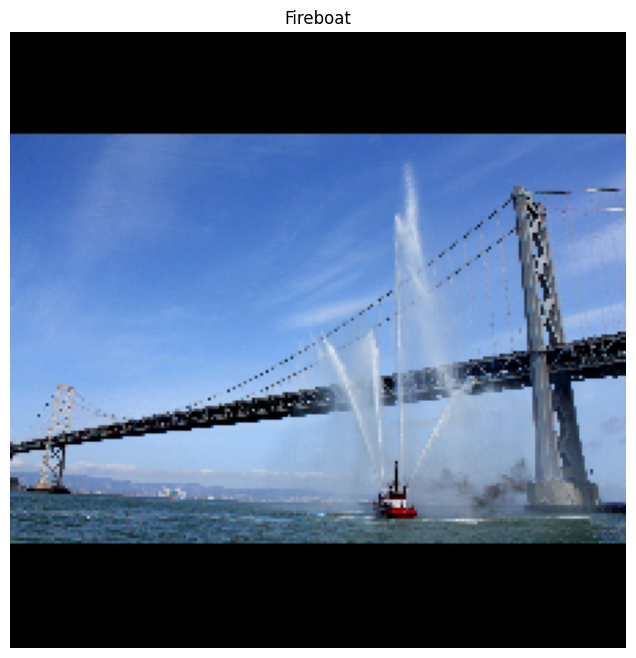

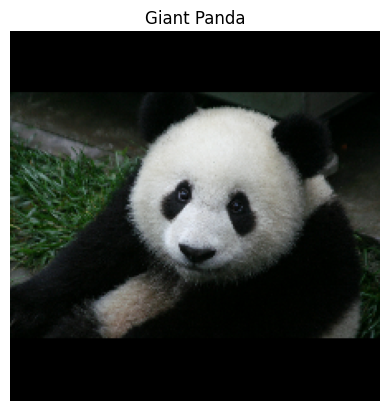

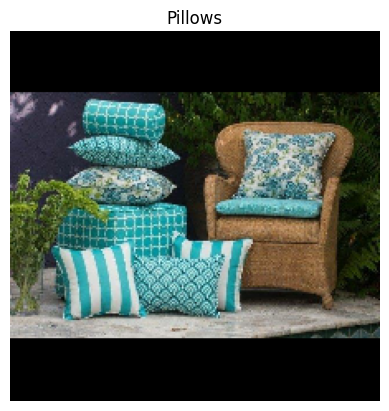

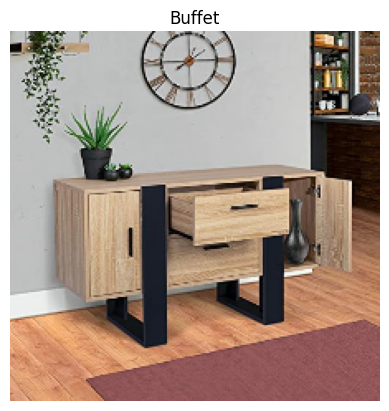

In [3]:
# ---------------------------------------------------------------------------- #
#                             CHARGEMENT DES IMAGES                            #
# ---------------------------------------------------------------------------- #

model = model.load_images({
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
    'Pillows': 'https://www.lecloudore87.fr/bckgd_img/9b4f9edf7f9ef8007419a0a534bce772.jpg',
    'Buffet': 'https://m.media-amazon.com/images/I/51hDVOFQycL._AC_.jpg',
}, display=True)

**Nous allons maintenant effectuer les prédictions au moyen de notre modèle déjà préentrainé.**

INFO:Model:Predicting images classes...
INFO:Model:Displaying predictions...


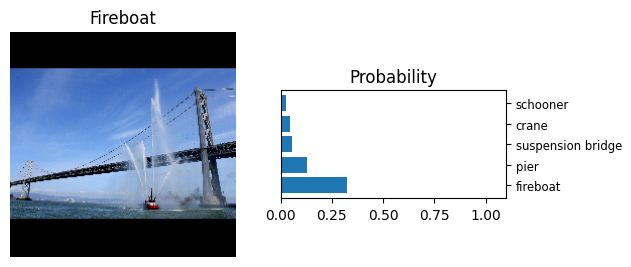

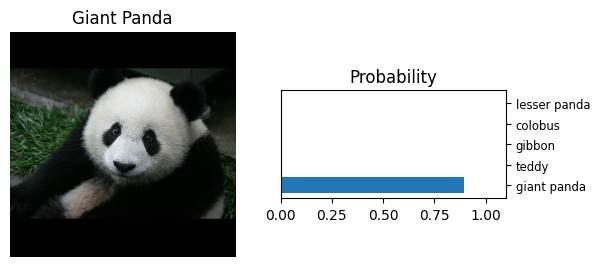

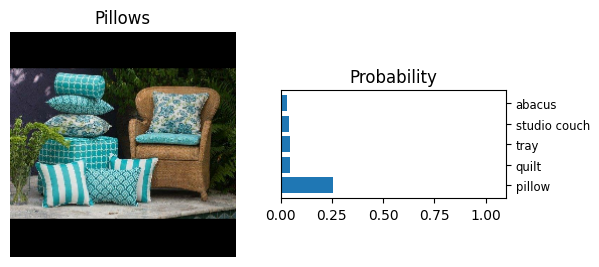

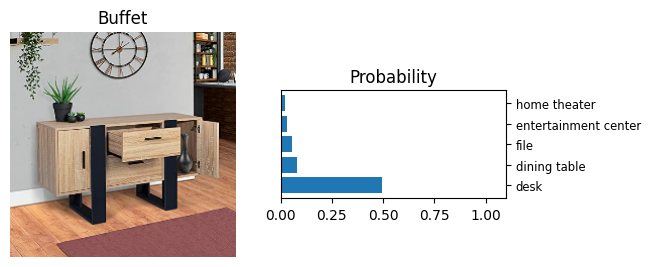

In [4]:
model.predict(display=True)

*On constate que les performances sont plutôt bonnes. Même dans le cas où le modèle ne dispose pas d'un label correspondant à l'image, il est capable de trouver un label très proche comme on peu le voir pour la dernière image.*

## Gradients Intégrés

Nous allons maintenant utiliser les gradients intégrés pour tenter d'expliquer les prédictions du modèle. 

**Décrivons en quelques mots l'intuition derrière les gradients integrés :**

Les premières techniques d'analyse de la performance des réseaux de neurones ont utilisé les gradients pour attribuer des scores d'importance aux caractéristiques. Les gradients indiquent quelles zones de l'image ont une influence la plus forte sur la prédiction du modèle à un instant donné. Cependant, ces gradients ne donnent qu'une vision partielle de la fonction de prédiction du modèle. Ils ne décrivent pas la fonction dans son ensemble. En outre, au fur et à mesure que le modèle apprend à mieux prédire, les gradients peuvent devenir plus faibles et même atteindre zéro. Cela signifie que les gradients ne sont pas une mesure fiable de l'importance des caractéristiques.

Par conséquent, plutôt que de se concentrer sur les gradients à un instant donné, nous pouvons utiliser les gradients intégrés pour calculer l'importance des caractéristiques en calculant la moyenne pondérée des gradients sur une série de valeurs intermédiaires entre une image de base (par exemple, une image complètement noire ou blanche) et l'image d'origine. Cela nous donne une vision plus complète de la fonction de prédiction du modèle.

*Mais pour effectuer ces calculs, nous avons besoin d'une image de base. Nous allons donc utiliser une image complètement noire.*

INFO:IntegratedGradients:Generating baseline image...
INFO:IntegratedGradients:Displaying baseline image...


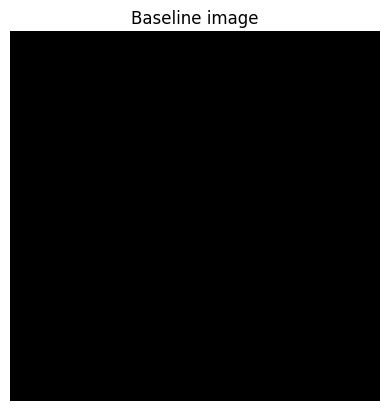

In [5]:
from IntegratedGradients import IntegratedGradients

integrator = IntegratedGradients(model=model, baseline_color="black").display_baseline()

### Interpolation des images

**Nous allons maintenant interpoler les images entre l'image de base et l'image d'origine.**

En effet, nous souhaitons étudier l'importance des caractéristiques de l'image d'origine en fonction de leur distance à l'image de base. Pour ce faire, nous allons gnérer $n$ variantes de chaque image, comme le barycentre pondéré à coefficients positifs entre l'image de base et l'image d'origine.
Nous pouvons retrouver cette idée dans la formule principale des gradients intégrés :

$$IG_i(x) = (x_i - x'_{_i}) \times \int_{\alpha=0}^1 \frac{\partial f(x' + \alpha (x - x'))}{\partial x_i} d\alpha$$

avec

- $(x_i - x'_{_i})$ : la différence entre la valeur de l'image d'origine et la valeur de l'image de base pour la caractéristique $i$.

- $f(x' + \alpha (x - x'))$ : la prédiction du modèle pour l'image $x$ interpolée avec l'image de base $x'$.

INFO:IntegratedGradients:Interpolating images...


12


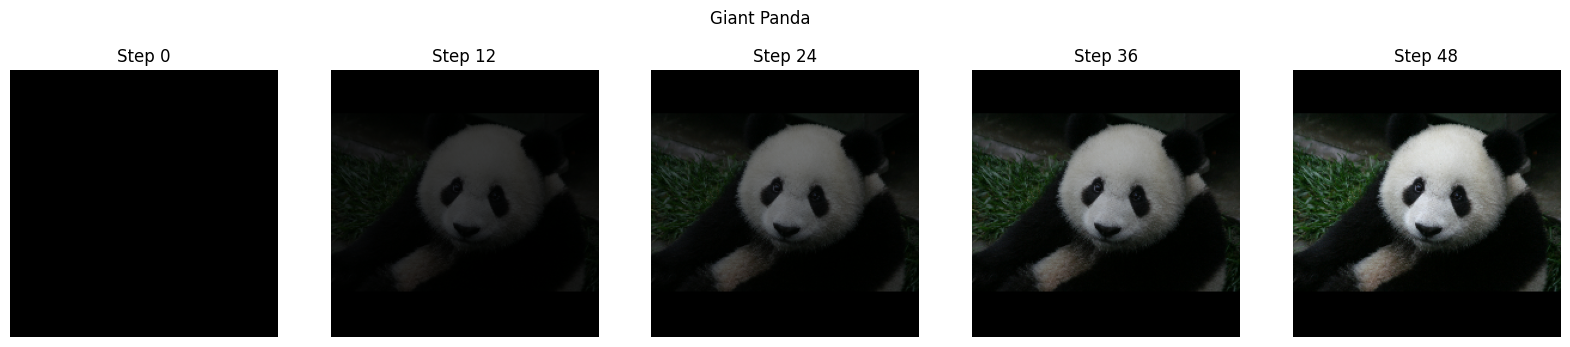

5


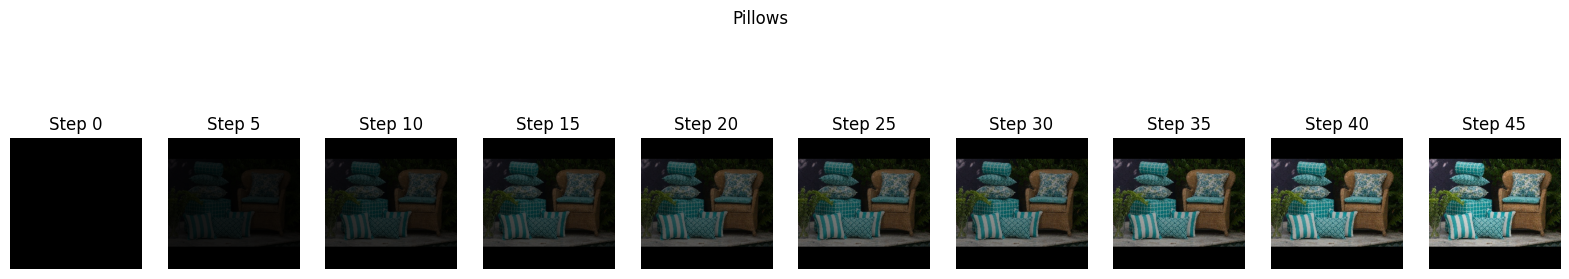

In [6]:
integrator.interpolate_images(display={"Giant Panda" : 5, "Pillows": 10})

### Calcul des gradients

**Nous allons maintenant calculer les gradients pour chaque caractéristique de l'image.**

Pour ce faire, nous nous intéressons cette fois ci à la dérivée partielle de notre formule qui permet d'évaluer la contribution de chaque caractéristique à la prédiction du modèle.

$$\frac{\partial f(\text{Image Interpolée})}{\partial x_i}$$

Nous allons donc calculer la dérivée partielle de la prédiction du modèle par rapport à la caractéristique $i$. Pour rendre le calcul possible, on approxime notre intégrale par la somme des gradients calculés pour chaque image interpolée :

$$IG_i(x) \simeq (x_i - x'_{_i}) \times \sum_{k=1}^m \frac{\partial f(\text{Image Interpolée})}{\partial x_i} \times \dfrac 1 m$$

INFO:IntegratedGradients:Computing average gradients for image Fireboat...
INFO:IntegratedGradients:Computing average gradients for image Giant Panda...


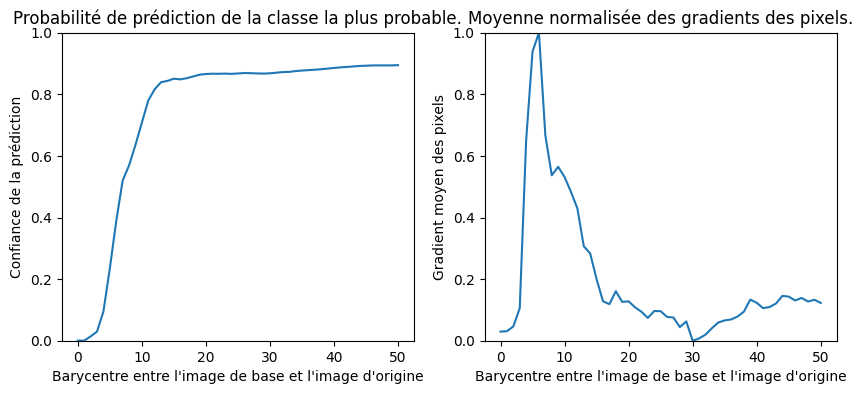

INFO:IntegratedGradients:Computing average gradients for image Pillows...


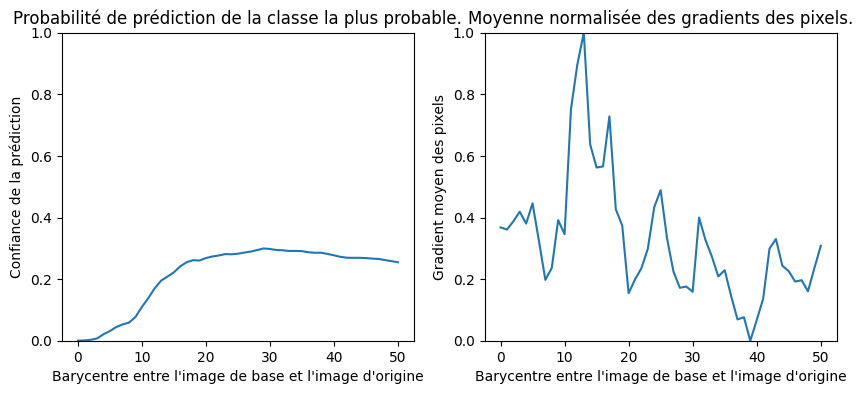

INFO:IntegratedGradients:Computing average gradients for image Buffet...


In [11]:
integrator.compute_gradients(display=["Giant Panda", "Pillows"])

### Intégration des gradients